In [401]:
from google.colab import drive
drive.mount("/content/drive")
%cd "drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive/RL on Stocks


In [402]:
%cd "RL on Stocks/"

[Errno 2] No such file or directory: 'RL on Stocks/'
/content/drive/My Drive/RL on Stocks


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler
final_result = []

# Let's use AAPL (Apple), MSI (Motorola), SBUX (Starbucks)
def get_data():
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  df = pd.read_csv('./aapl_msi_sbux.csv')
  return df.values





def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here

  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler




def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)



class LinearModel:
  """ A linear regression model """
  def __init__(self, input_dim, n_action):
    self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
    self.b = np.zeros(n_action)

    # momentum terms
    self.vW = 0
    self.vb = 0

    self.losses = []

  def predict(self, X):
    # make sure X is N x D
    assert(len(X.shape) == 2)
    return X.dot(self.W) + self.b

  def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
    # make sure X is N x D
    assert(len(X.shape) == 2)

    # the loss values are 2-D
    # normally we would divide by N only
    # but now we divide by N x K
    num_values = np.prod(Y.shape)

    # do one step of gradient descent
    # we multiply by 2 to get the exact gradient
    # (not adjusting the learning rate)
    # i.e. d/dx (x^2) --> 2x
    Yhat = self.predict(X)
    gW = 2 * X.T.dot(Yhat - Y) / num_values
    gb = 2 * (Yhat - Y).sum(axis=0) / num_values

    # update momentum terms
    self.vW = momentum * self.vW - learning_rate * gW
    self.vb = momentum * self.vb - learning_rate * gb

    # update params
    self.W += self.vW
    self.b += self.vb

    mse = np.mean((Yhat - Y)**2)
    self.losses.append(mse)

  def load_weights(self, filepath):
    npz = np.load(filepath)
    self.W = npz['W']
    self.b = npz['b']

  def save_weights(self, filepath):
    np.savez(filepath, W=self.W, b=self.b)




class MultiStockEnv:
  """
  A 3-stock trading environment.
  State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
  Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
  """
  def __init__(self, data, initial_investment=20000):
    # dat
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = np.arange(3**self.n_stock)

    # action permutations
    # returns a nested list with elements like:
    # [0,0,0]
    # [0,0,1]
    # [0,0,2]
    # [0,1,0]
    # [0,1,1]
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy
    self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))
    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()


  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()


  def step(self, action):
    assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
    info = {'cur_val': cur_val}

    # conform to the Gym API
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


  def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock
    action_vec = self.action_list[action]

    # determine which stocks to buy or sell
    sell_index = [] # stores index of stocks we want to sell
    buy_index = [] # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # sell any stocks we want to sell
    # then buy any stocks we want to buy
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      # NOTE: when buying, we will loop through each stock we want to buy,
      #       and buy one share at a time until we run out of cash
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False




class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = LinearModel(state_size, action_size)

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action


  def train(self, state, action, reward, next_state, done):
    if done:
      target = reward
    else:
      target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

    target_full = self.model.predict(state)
    #print(target_full)
    #print("-------")
    target_full[0, action] = target
    
    # Run one training step
    self.model.sgd(state, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


  def load(self, name):
    self.model.load_weights(name)


  def save(self, name):
    self.model.save_weights(name)


def play_one_episode(agent, env, is_train, n):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False
  actions = []
  while not done:
    action = agent.act(state)
    actions.append(env.action_list[action])
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.train(state, action, reward, next_state, done)
    state = next_state

  
  
  final_result.append({"actions": actions, "profit_loss": info['cur_val']})
  return info['cur_val']



if __name__ == '__main_':

  # config
  models_folder = 'linear_rl_trader_models'
  rewards_folder = 'linear_rl_trader_rewards'
  num_episodes = 2000
  batch_size = 32
  initial_investment = 20000


  #parser = argparse.ArgumentParser()
  #parser.add_argument('-m', '--mode', type=str, required=True,
  #                    help='either "train" or "test"')
  #args = parser.parse_args()

  maybe_make_dir(models_folder)
  maybe_make_dir(rewards_folder)

  data = get_data()
  n_timesteps, n_stocks = data.shape

  n_train = n_timesteps // 2

  train_data = data[:n_train]
  test_data = data[n_train:]

  env = MultiStockEnv(train_data, initial_investment)
  state_size = env.state_dim
  action_size = len(env.action_space)
  agent = DQNAgent(state_size, action_size)
  scaler = get_scaler(env)

  # store the final value of the portfolio (end of episode)
  portfolio_value = []

  if args.mode == 'test':
    # then load the previous scaler
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
      scaler = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

    # make sure epsilon is not 1!
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    agent.epsilon = 0.01

    # load trained weights
    agent.load(f'{models_folder}/linear.npz')

  # play the game num_episodes times
  for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, args.mode)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val) # append episode end portfolio value

  # save the weights when we are done
  if args.mode == 'train':
    # save the DQN
    agent.save(f'{models_folder}/linear.npz')

    # save the scaler
    with open(f'{models_folder}/scaler.pkl', 'wb') as f:
      pickle.dump(scaler, f)

    # plot losses
    plt.plot(agent.model.losses)
    plt.show()


  # save portfolio value for each episode
  np.save(f'{rewards_folder}/{args.mode}.npy', portfolio_value)


**###TEST CODE**

In [0]:
  # config
  models_folder = 'linear_rl_trader_models'
  rewards_folder = 'linear_rl_trader_rewards'
  num_episodes = 2000
  batch_size = 32
  initial_investment = 20000


  #parser = argparse.ArgumentParser()
  #parser.add_argument('-m', '--mode', type=str, required=True,
  #                    help='either "train" or "test"')
  #args = parser.parse_args()

  maybe_make_dir(models_folder)
  maybe_make_dir(rewards_folder)

  data = get_data()
  n_timesteps, n_stocks = data.shape

  n_train = n_timesteps // 2

  train_data = data[:n_train]
  test_data = data[n_train:]

  env = MultiStockEnv(train_data, initial_investment)
  state_size = env.state_dim
  action_size = len(env.action_space)
  agent = DQNAgent(state_size, action_size)
  scaler = get_scaler(env)

  # store the final value of the portfolio (end of episode)
  portfolio_value = []
  mode = 'train'

  if mode == 'test':
    # then load the previous scaler
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
      scaler = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

    # make sure epsilon is not 1!
    # no need to run multiple episodes if epsilon = 0, it's deterministic
    agent.epsilon = 0.01

    # load trained weights
    agent.load(f'{models_folder}/linear.npz')


episode: 1/2000, episode end value: 25003.01, duration: 0:00:00.214200
episode: 2/2000, episode end value: 35671.32, duration: 0:00:00.217600
episode: 3/2000, episode end value: 42282.70, duration: 0:00:00.205519
episode: 4/2000, episode end value: 35192.68, duration: 0:00:00.165344
episode: 5/2000, episode end value: 42690.58, duration: 0:00:00.141351
episode: 6/2000, episode end value: 39679.54, duration: 0:00:00.134526
episode: 7/2000, episode end value: 36585.67, duration: 0:00:00.140397
episode: 8/2000, episode end value: 34551.00, duration: 0:00:00.148016
episode: 9/2000, episode end value: 34403.19, duration: 0:00:00.161066
episode: 10/2000, episode end value: 39849.54, duration: 0:00:00.185813
episode: 11/2000, episode end value: 49967.46, duration: 0:00:00.123271
episode: 12/2000, episode end value: 41165.68, duration: 0:00:00.123464
episode: 13/2000, episode end value: 43185.63, duration: 0:00:00.113318
episode: 14/2000, episode end value: 42274.80, duration: 0:00:00.116599
e

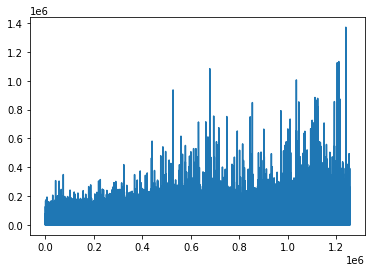

In [405]:

  # play the game num_episodes times
  for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, mode, e)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val) # append episode end portfolio value

  if mode == 'train':
    # save the DQN
    agent.save(f'{models_folder}/linear.npz')

    # save the scaler
    with open(f'{models_folder}/scaler.pkl', 'wb') as f:
      pickle.dump(scaler, f)

    # plot losses
    plt.plot(agent.model.losses)
    plt.show()

In [0]:
df1 = pd.DataFrame(final_result)

In [407]:
max_index = df1['profit_loss'].idxmax()
actions = df1.iloc[max_index]
actions

actions        [[1, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [...
profit_loss                                              89549.5
Name: 919, dtype: object

In [0]:
actions = (pd.DataFrame(data=actions.actions, columns=['AAPL_', 'MSI_', 'SBUX_']))

In [409]:
actions

,AAPL_,MSI_,SBUX_
0,1,1,2
1,0,1,2
2,0,1,2
3,0,1,2
4,0,1,2
...,...,...,...
623,0,2,2
624,0,2,2
625,0,2,2
626,2,1,0


Test Dataset

In [0]:
df2 = pd.DataFrame(data=train_data, columns=['AAPL', 'MSI', 'SBUX'])

In [0]:
#df2 = df2[:-1]; df2 = df2[1:].reset_index()

#df2 = df2[2:].reset_index()

df2 = df2[:-2].reset_index()

Merging Actions with Prices

In [0]:
df3 = pd.concat([df2, actions], axis=1)#[['AAPL_', 'MSI_', 'SBUX_']].iloc[:-2].astype('int')

In [0]:
df3[['AAPL_', 'MSI_', 'SBUX_']] = df3[['AAPL_', 'MSI_', 'SBUX_']].astype('int')

In [414]:
df3

,index,AAPL,MSI,SBUX,AAPL_,MSI_,SBUX_
0,0.0,67.8542,60.30,28.185,1,1,2
1,1.0,68.5614,60.90,28.070,0,1,2
2,2.0,66.8428,60.83,28.130,0,1,2
3,3.0,66.7156,60.81,27.915,0,1,2
4,4.0,66.6556,61.12,27.775,0,1,2
...,...,...,...,...,...,...,...
623,623.0,121.3000,60.16,57.930,0,2,2
624,624.0,118.4400,59.76,58.190,0,2,2
625,625.0,114.6400,60.22,58.700,0,2,2
626,626.0,115.4000,64.04,59.010,2,1,0


In [0]:
aapl_sell = df3[df3['AAPL_']==0][['AAPL', 'AAPL_']]
aapl_buy = df3[df3['AAPL_']==2][['AAPL', 'AAPL_']]

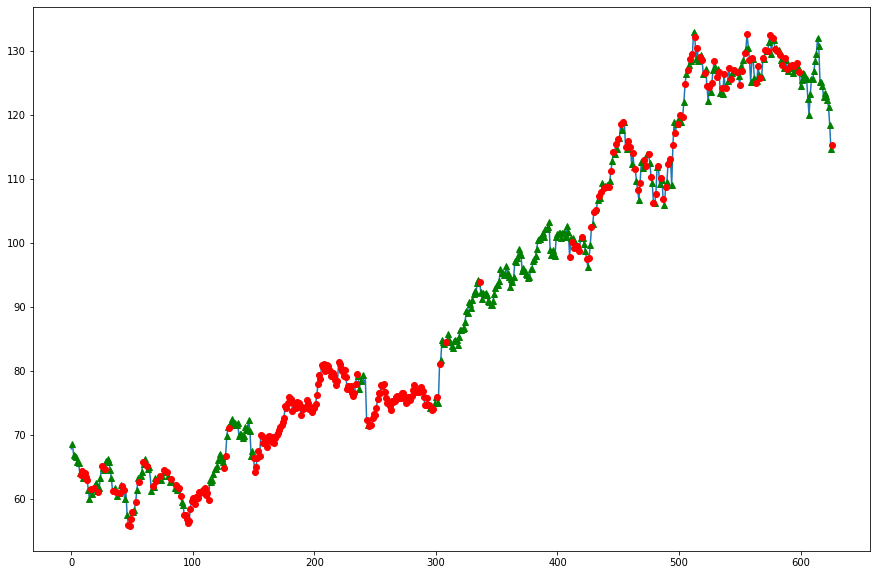

In [416]:
import matplotlib.pyplot as plt
import numpy as np
import argparse

plt.figure(figsize=(15,10))
plt.plot(df2.index, df2['AAPL'])
#plt.plot(df2.index, df2['MSI'])
#plt.plot(df2.index, df2['SBUX'])
plt.plot(aapl_sell.index, aapl_sell['AAPL'], 'r^', color="green")
plt.plot(aapl_buy.index, aapl_buy['AAPL'], 'ro')
